# Depiction - A meta-interpretability toolbox

## Why interpretability?

In the last decade, the application of deep neural networks to long-standing problems has brought a break-through in performance and prediction power. However, high accuracy, deriving from the increased model complexity, often comes at the price of loss of interpretability, i.e., many of these models behave as black-boxes and fail to provide explanations on their predictions. While in certain application fields this issue may play a secondary role, in high risk domains, e.g., health care, it is crucial to build trust in a model and being able to understand its behaviour.

## What is interpretability?

The definition of the verb *interpret* is "to explain or tell the meaning of : present in understandable terms" ([Merriam-Webster 2019](https://www.merriam-webster.com/dictionary/interpret)). Despite the apparent simplicity of this statement, the machine learning research community is struggling to agree upon a formal definition of the concept of interpretability/explainability. In the last years, in the room left by this lack of formalism, many methodologies have been proposed based on different "interpretations" (pun intended) of the above defintion. While the proliferation of this multitude of disparate algorithms has posed challenges on rigorously comparing them, it is nevertheless interesting and useful to apply these techniques to analyze the behaviour of deep learning models.

## What is this tutorial about?

This tutorial focuses on illustrating some of the recent advancements in the field of interpretable deep learning. We will show common techniques that can be used to explain predictions on pretrained models and that can be used to shed light on their inner mechanisms. The tutorial is aimed to strike the right balance between theoretical input and practical exercises. The session has been designed to provide the participants not only with the theory behind deep learning interpretability, but also to offer a set of frameworks and tools that they can easily reuse in their own projects.

## Depiction

The group of Cognitive Health Care and Life Sciences at IBM Research Zürich has opensourced a python toolbox, [depiction](https://github.com/IBM/depiction), with the aim of providing a framework to ease the application of explainability methods on custom models, especially for less experienced users. The module provide wrappers for multiple algorithms and is continously updated including the latest algorithms from [AIX360](https://github.com/IBM/AIX360.git). The core concept behind depiction is to allow users to seamlessly run state-of-art interpretability methods with minimal requirements in terms of programming skills. Below an example of how depiction can be used to analyze a pretrained model.

### A simple example - Wrapping a pretrained Keras Model

Let's assume to have a fancy model for classification of tabular data pretrained in Keras and available at a public url. Explaining its predictions with `depiction` is easy as implementing a lightweight wrapper of `depiction.models.uri.HTTPModel` where its `predict` method is overridden.

```python
from depiction.core import Task, DataType
from depiction.models.uri import HTTPModel


class FancyModel(HTTPModel):
    """A fancy classifier."""


    def __init__(self,
        filename='fancy_model.h5',
        origin='https://url/to/my/fancy_model.h5',
        cache_dir='/path/to/cache/models',
        *args, **kwargs):
        """Initialize the FancyModel."""
        super().__init__(
            uri=origin,
            task=Task.CLASSIFICATION,
            data_type=DataType.TABULAR,
            cache_dir=cache_dir,
            filename=filename
        )
        self.model = keras.models.load_model(self.model_path)

    def predict(self, sample, *args, **kwargs):
        """
        Run the fancy model for inference on a given sample and with the provided
        parameters.

        Args:
            sample (object): an input sample for the model.
            args (list): list of arguments.
            kwargs (dict): list of key-value arguments.

        Returns:
            a prediction for the model on the given sample.
        """
        return self.model.predict(
            sample,
            batch_size=None, verbose=0,
            steps=None, callbacks=None
        )
```

Once `FancyModel` is implemented, using any of the `depiction.interpreters` available in the library, is as easy as typing:

```python
fancy_model = FancyModel()
# NOTE: interpreters are implemented inheriting from
# depiction.interpreters.base.base_interpreter.BaseInterpreter
# and they share a common interface.
explanations = interpreter.interpret(example)
```

### Another simple example - Rule-based interpretable method

Here we show as an example how *easy* is to use **Generalized linear rule models** in `depiction` [(Wei D. et al. 2019)](http://proceedings.mlr.press/v97/wei19a/wei19a.pdf). Note that in this example we are using the model as an *ante-hoc global interpretable method*. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from depiction.interpreters.aix360.rule_based_model import RuleAIX360

In [2]:
# Create dataset. 
# NOTE: for the purpose of this example, we will ignore some ML best practices, 
#       such as train-validation-test splitting.
dataset = load_iris()

X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
# Rule-based explainers work only with binary classifiers.
# In this example, we want to explain class 'setosa'
y = np.array(dataset.target == np.where(dataset.target_names == 'setosa')).astype(np.int).flatten()

In [3]:
# Create explainable model
explainable_model = RuleAIX360('glrm_linear', X=X, y=y)

In [4]:
# Explain model
pd.set_option('display.max_colwidth', -1)
explainable_model.interpret();

                                                   rule coefficient
0  (intercept)                                           0.524881  
1  sepal width (cm) > 2.70 AND petal width (cm) <= 1.16  0.616186  
2  petal length (cm) > 1.70 AND petal width (cm) > 0.40 -0.587525  
3  sepal length (cm) > 5.27 AND petal width (cm) > 0.40 -0.0871229 
4  sepal width (cm) <= 3.20 AND petal width (cm) > 0.40 -0.0698256 
5  petal width (cm) <= 1.16                              0.0311023 
6  petal width (cm) <= 0.40                              0.0122838 
7  petal length (cm) <= 1.70                             0.012283  
8  petal length (cm) <= 3.90                            -0.00140309


Since the *iris* dataset is a relatively easy one, i.e., it can be solved with a linear model, we can easily double check if the rules learned by the **interpretable model** make sense. In the following, we show the samples from the dataset on a 2D plot where the axes are the *sepal width* and *petal width*. The *setosa* samples are shown in blue, while the others are in red. The blue area denotes the region described by the most important rule inferred by the interpretable model (line 1 of the output).

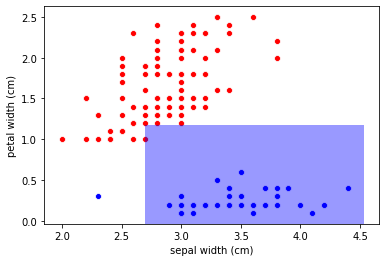

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x="sepal width (cm)", y="petal width (cm)", data=X.iloc[y == 1], color='b')
sns.scatterplot(x="sepal width (cm)", y="petal width (cm)", data=X.iloc[y == 0], color='r')
ax = plt.gca()
ax.axvspan(xmin=2.70, xmax=ax.get_xlim()[1], ymin=0, ymax=(1.16 - ax.get_ylim()[0])/ax.get_ylim()[1], facecolor='b', alpha=0.4)